
# TP CNN
### Martiros Yeghiazaryan

## Introduction

In [2]:
from IPython.display import Image
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt


2.11.0


**The GPU**



To enable GPU backend in Google colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save.

Or run the next cell:

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


## Convolutional Neural Networks (CNN)

Derived from the MLP, a convolutional neural network (CNN) is a type of artificial neural network that is specifically designed to process **pixel data**.  The layers of a CNN consist of an **input layer**, an **output layer** and **hidden layers** that can include **convolutional layers**, **pooling layers**, **fully connected layers** and **normalization layers**. There exists a lot of techniques to optimize CNN, like for example the dropout.

### Loading the dataset
In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


To feed the data to a CNN, we need to shape it as required by Keras. As input, a 2D convolutional layer needs a **4D tensor** with shape: **(batch, rows, cols, channels)**. Therefore, we need to precise the "channels" axis, which can be seen as the number of level of color of each input: 3 channels in our case. We will fix the dimension of images according to the VGG-16 network: (224, 224).


In [9]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay 

### loading train data

Please read the code before running any of the cells!

In [12]:
# datasetRoot='/home/lingrand/Ens/MachineLearning/animals/raw-img/'
#datasetRoot='/whereYouPutTheImages/'
datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial. 
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto'] #, 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)


100%|██████████| 200/200 [00:25<00:00,  7.85it/s]

600
(600, 224, 224, 3)


In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.

### loading test data

In [13]:
#you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot+'test/'
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest+cl+'/*'))

print("There are ",totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg,224,224,3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTest[i,:,:,:] = im 
        i += 1
    classLabel += 1
print(len(yTest))
print(xTest.shape)
yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)

There are  991  images in test dataset.
991
(991, 224, 224, 3)


## Build your own CNN network

Start with the simplest CNN: 1 conv2D layer + 1 pooling + 1 dense layer.

In [20]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=4, padding='same'))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=4, padding='same'))
model.add(Flatten())
model.add(Dense(nbClasses, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

Let's look at the dimension of all inputs and outputs:

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                  

Learn and test this network. 

In [22]:
# for you !
ourCallbacks = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, mode='auto', baseline=None, restore_best_weights=True, verbose=2)
history = model.fit(xTrain, yTrain, batch_size=32, epochs=1000, callbacks=[ourCallbacks], validation_split=0.2, verbose=2)

Epoch 1/1000
15/15 - 4s - loss: 21.4722 - accuracy: 0.4146 - val_loss: 2.6415 - val_accuracy: 0.1500 - 4s/epoch - 245ms/step
Epoch 2/1000
15/15 - 1s - loss: 1.0500 - accuracy: 0.5604 - val_loss: 3.6840 - val_accuracy: 0.0333 - 1s/epoch - 70ms/step
Epoch 3/1000
15/15 - 1s - loss: 0.9157 - accuracy: 0.6208 - val_loss: 2.4688 - val_accuracy: 0.1083 - 997ms/epoch - 66ms/step
Epoch 4/1000
15/15 - 1s - loss: 1.1926 - accuracy: 0.5896 - val_loss: 1.4026 - val_accuracy: 0.4250 - 1s/epoch - 70ms/step
Epoch 5/1000
15/15 - 1s - loss: 0.7089 - accuracy: 0.7125 - val_loss: 0.5880 - val_accuracy: 0.7583 - 948ms/epoch - 63ms/step
Epoch 6/1000
15/15 - 1s - loss: 0.6015 - accuracy: 0.7583 - val_loss: 1.0886 - val_accuracy: 0.4667 - 1s/epoch - 68ms/step
Epoch 7/1000
15/15 - 1s - loss: 0.4952 - accuracy: 0.8104 - val_loss: 0.6360 - val_accuracy: 0.7250 - 944ms/epoch - 63ms/step
Epoch 8/1000
15/15 - 1s - loss: 0.3390 - accuracy: 0.8646 - val_loss: 0.3327 - val_accuracy: 0.8833 - 940ms/epoch - 63ms/step
Ep

In [23]:
# for you !
score = model.evaluate(xTest,yTest)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

ypred = np.argmax(model.predict(xTest), axis=1)
print("F1 score: ", f1_score(ypred,np.argmax(yTest,axis=1),average=None))

31/31 [==============================] - 1s 34ms/step - loss: 1.1248 - accuracy: 0.6720
accuracy: 67.20%
31/31 [==============================] - 1s 22ms/step
F1 score:  [0.70663265 0.50678733 0.73280423]


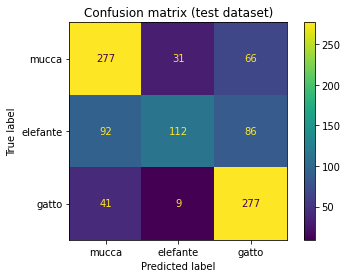

In [26]:
cm = confusion_matrix(np.argmax(yTest,axis=1), ypred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

How is the accuracy or F1-measure on the test dataset?

Are you satisfied by the performances?

Try to modify the architecture (add layers) and some of the parameters.

### About Dropout 

*Study this part only if you have time for it. It concerns the previous network but prefer to study first part II and come back here after.*

Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.

Why use dropout ? A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to overfitting of training data.

**Let's add dropout and activation functions to the network!**

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential(name='MLP model with dropout') 

model = Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(200,activation='relu'))
# adding dropout to the previous layer
model.add(Dropout(0.2))

model.add(Dense(nbClasses, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# learn again your CNN with dropout

## Using a pre-learned network

### loading VGG-16 description part and adding layers to build our own classification network

In [24]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
VGGmodel.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [25]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
m = Dense(1024, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


Can you display the architecture of this entire network?

In [27]:
# for you
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
# training
ourCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
 
# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/2000
4/4 [==============================] - 27s 6s/step - loss: 7.2431 - accuracy: 0.5562 - val_loss: 0.0199 - val_accuracy: 0.9917
Epoch 2/2000
4/4 [==============================] - 2s 608ms/step - loss: 0.0737 - accuracy: 0.9812 - val_loss: 0.0879 - val_accuracy: 0.9667
Epoch 3/2000
4/4 [==============================] - 2s 656ms/step - loss: 0.0280 - accuracy: 0.9937 - val_loss: 0.0876 - val_accuracy: 0.9667
Epoch 4/2000
4/4 [==============================] - 2s 639ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0827 - val_accuracy: 0.9667
Epoch 5/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9667
Epoch 6/2000
4/4 [==============================] - 2s 665ms/step - loss: 9.7970e-04 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.9667
Epoch 7/2000
4/4 [==============================] - 2s 624ms/step - loss: 7.6305e-04 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.9667


In [29]:
model.evaluate(xTest, yTest)

31/31 [==============================] - 9s 209ms/step - loss: 0.1359 - accuracy: 0.9828


[0.13587047159671783, 0.9828456044197083]

In [30]:
yPred = model.predict(xTest)
yPred

31/31 [==============================] - 4s 117ms/step


array([[1.0000000e+00, 3.8867941e-25, 3.6876158e-17],
       [1.0000000e+00, 3.0712144e-17, 1.7377095e-20],
       [4.6349365e-02, 9.5365071e-01, 2.5659282e-12],
       ...,
       [1.7225210e-15, 5.3407657e-23, 1.0000000e+00],
       [3.7778068e-15, 2.2355143e-20, 1.0000000e+00],
       [2.6980321e-16, 1.6850892e-18, 1.0000000e+00]], dtype=float32)

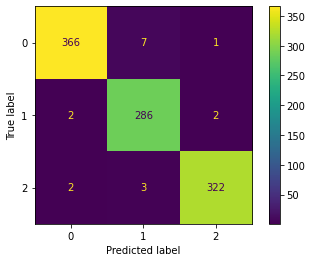

In [31]:
ConfusionMatrixDisplay.from_predictions(np.argmax(yTest, axis=1), np.argmax(yPred, axis=1))

### fine-tune the network

Fine-tune the entire network if you have enough computing ressouces, otherwise, carefully choose the layers you want to fine-tune.

In [32]:
for i, layer in enumerate(VGGmodel.layers):
   print(i, layer.name)
model.summary()

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None,

In this example, we will fine-tune the last convolution block starting at layer number 15 (block5_conv).

In [33]:
from tensorflow.keras.optimizers import RMSprop
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True
#need to recompile the network
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
#and train again ...
model.fit(xTrain, yTrain, epochs=20, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/20
4/4 [==============================] - 12s 2s/step - loss: 17.9676 - accuracy: 0.8979 - val_loss: 0.0313 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 3s 815ms/step - loss: 1.7954 - accuracy: 0.4375 - val_loss: 2.1200 - val_accuracy: 0.1667
Epoch 3/20
4/4 [==============================] - 3s 811ms/step - loss: 0.9315 - accuracy: 0.5875 - val_loss: 0.9672 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 3s 875ms/step - loss: 0.8040 - accuracy: 0.6208 - val_loss: 0.4210 - val_accuracy: 0.8667
Epoch 5/20
4/4 [==============================] - 3s 822ms/step - loss: 0.5634 - accuracy: 0.8250 - val_loss: 0.3003 - val_accuracy: 0.8917
Epoch 6/20
4/4 [==============================] - 3s 866ms/step - loss: 1.0087 - accuracy: 0.7500 - val_loss: 0.8632 - val_accuracy: 0.6083
Epoch 7/20
4/4 [==============================] - 3s 827ms/step - loss: 0.5009 - accuracy: 0.8083 - val_loss: 0.7185 - val_accuracy: 0.7167
Epoch 8/20
4/4 [=====

You already know how to evaluate the performances on the test dataset and display the confusion matrix. You can also modify the code that loads the test dataset in order to reduce it's size. Let's do it!

In [34]:
#enter here your code for evaluation of performances
model.evaluate(xTest, yTest)

31/31 [==============================] - 4s 122ms/step - loss: 0.7373 - accuracy: 0.6660


[0.7373113632202148, 0.6659939289093018]

You are now free to experiments changes in the network:
* add a dense layer
* modify the number of neurons in dense layer(s)
* change the global average polling
* add classes and data
* experiment other optimizers (SGD, Adam, ...)


...

In [37]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output

# change it to global max pooling
m = GlobalMaxPooling2D()(m)

# and add a fully-connected layer
m = Dense(256, activation="relu")(m) # modify the number of neurons in dense layer
m = Dense(256, activation="relu")(m) # add a second dense layer

# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation="softmax")(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)
print(model.summary())

# compile
model.compile(
    optimizer=Adam(learning_rate=0.0001), # try other optimizer
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# fit model
model.fit(
    xTrain,
    yTrain,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=[ourCallback],
    verbose=1,
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [38]:
model.evaluate(xTest, yTest)

31/31 [==============================] - 4s 120ms/step - loss: 0.4698 - accuracy: 0.9051


[0.4697534143924713, 0.9051463007926941]

31/31 [==============================] - 4s 119ms/step


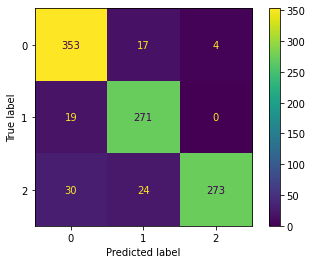

In [39]:
yPred = model.predict(xTest)
ConfusionMatrixDisplay.from_predictions(np.argmax(yTest, axis=1), np.argmax(yPred, axis=1))